### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 7
### Due: Saturday, Mar 30th at 11.59pm CT
---

This is a regression problem. Many of the parts require minor variations of code to switch to new techniques, but otherwise using a similar workflow. 

Note of warning: the data I have provided have associated uncertainties, `yerr`. `sklearn` and `astroML` have different formats for using uncertainties; in `sklearn` fitting you can provide `sample_weight=1/yerr**2`, while in `astroML` fitting you can directly provide `y_error=yerr`.

1. Read in `hw7_data_1.npy`. The dataset should consist of $500$ samples. The first two columns are the two data features, `X`. The third column is the target labels, `y`, and the final column are the heteroscedastic uncertainties on the labels, `yerr`. Make a 2-panel scatter plot of the labels versus each feature.


2. Use multivariate linear regression on this data with its uncertainties (`astroML` rather than plain `sklearn` is the better option here). Print the best-fit intercept and slopes for the features. Make a prediction `Xgrid` over $50$ values from the min to the max value of each feature, and plot the best-fit model on a duplicate of the $2$-panel plot from (1); does this look like a good description of the data?


3. Make a new two-dimensional prediction meshgrid `Xgrid` over the $2$-D feature space, use your best-fit model to predict the labels, and make a $3$-D interactive plot showing the data and your best-fit over the entire space. You may find the following code useful.

In [121]:
# install the relevant interactive plot packages
# only do this once
!pip install ipywidgets ipympl

Making Scatter Plots

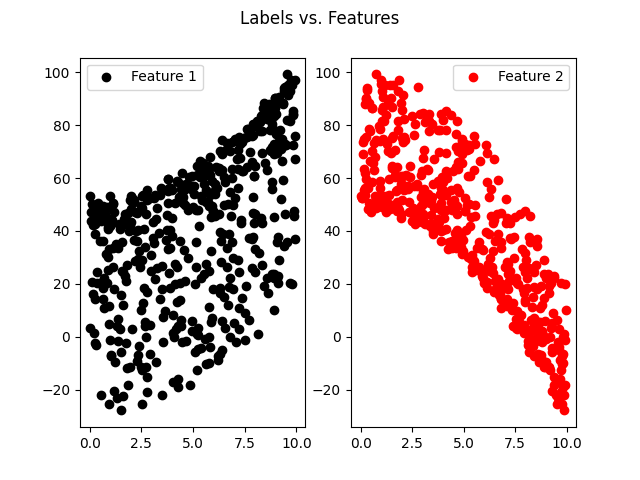

In [219]:
import os
import numpy as np
np.bool = np.bool_ #patching issue caused by numpy update conflicting with these packages 
from matplotlib import pyplot as plt

os.chdir('/home/hoelsczj/repos/astr_8070_S24/coursework/homeworks/hw_data/')
HWData=np.load('hw7_data_1.npy')

Feature1=HWData[:,0]
Feature2=HWData[:,1]
X=np.column_stack((Feature1,Feature2)) #Feature 1 in first column, Feature 2 in second column 
y=HWData[:,2] #Target labels 
yerr=HWData[:,3] #Target labels error

figure, (ax1, ax2) = plt.subplots(1, 2) #setting up two side by side plots 
figure.suptitle('Labels vs. Features')

ax1.scatter(Feature1, y, label="Feature 1", color="k")
ax2.scatter(Feature2, y, label="Feature 2", color="red")
ax1.legend()
ax2.legend()
plt.show()


Doing linear regression

In [204]:
from astroML.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y, yerr) #conducting the multivariate linear regression fit 

print("y-intercept, slope for feature 1, slope for feature 2: ")
print(model.coef_)

y-intercept, slope for feature 1, slope for feature 2: 
[57.10102323  4.94873016 -8.30023407]


Plotting lines from linear regression 

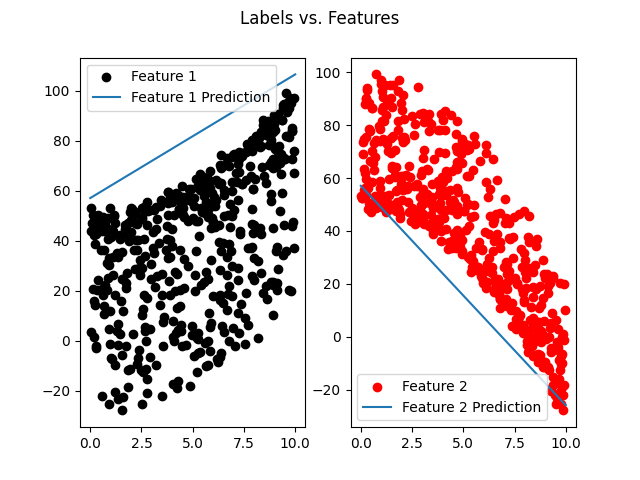

In [205]:
XGrid=np.linspace(0,10,50)
Feature1_Prediction=model.coef_[0]+model.coef_[1]*XGrid #creating arrays for points on the fitted lines (really hyperplane)
Feature2_Prediction=model.coef_[0]+model.coef_[2]*XGrid

plt.clf() #clearing the old plot out 
figure, (ax1, ax2) = plt.subplots(1, 2) #setting up two side by side plots 
figure.suptitle('Labels vs. Features')

ax1.scatter(Feature1, y, label="Feature 1", color="k")
ax2.scatter(Feature2, y, label="Feature 2", color="red")
ax1.plot(XGrid, Feature1_Prediction, label="Feature 1 Prediction") #plotting the fitted lines 
ax2.plot(XGrid, Feature2_Prediction, label="Feature 2 Prediction")
ax1.legend()
ax2.legend()
plt.show()

No, it does not seem like this provides a particularly great fit. Note that the line for feature 1 is above all the points because the y-intercept is too high.

Making interactive plot of the linear regression fit. Blue dots are on the fitted hyperplane. 

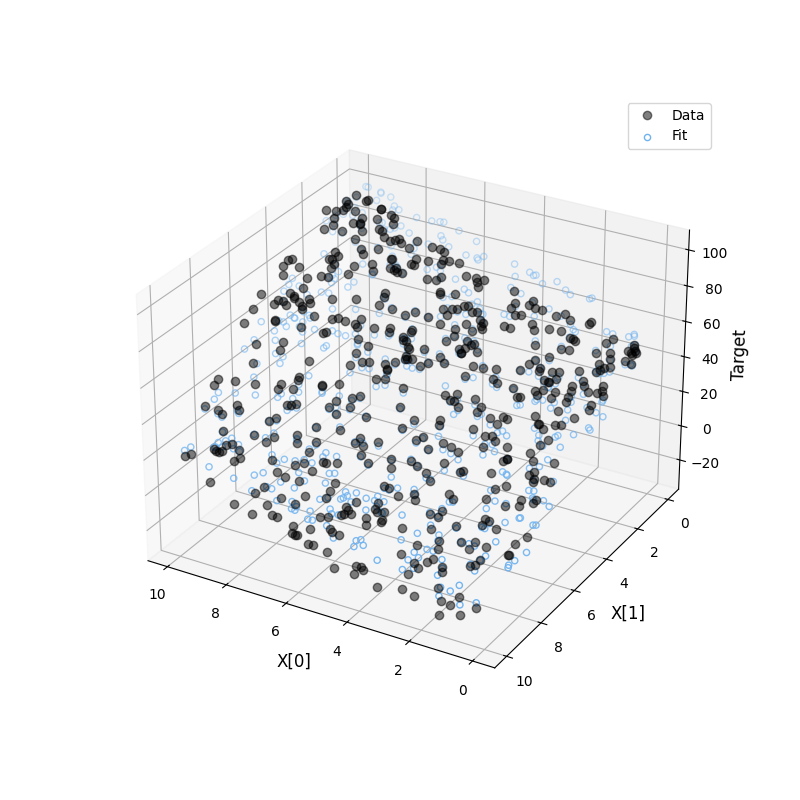

In [206]:
# Makes the plot interactive. 
# You can pan the image.
from collections.abc import Mapping
### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Feature1, Feature2, y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5, label="Data")

Prediction=model.coef_[0]+Feature1*model.coef_[1]+Feature2*model.coef_[2]
ax.scatter(Feature1, Feature2, Prediction, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0', label="Fit")
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)
ax.view_init(elev=28, azim=120)
ax.legend()



4. Sticking with a linear model, now attempt a `GridSearchCV` procedure on the data to find the best `Ridge` regression hyper-parameters. Use the following `param_grid`:
```
ridge_params = {'alpha': [0.05,0.1,0.2,0.5,1.0], 'solver': ['svd', 'lsqr']}
```
What are the `best_params_` and the `best_score_` from this? Fit the data with the best options, and visualize interactively. Try `RidgeCV` also; what cross-validated `alpha_` does it return, and does this agree with `GridSeachCV`? *(Hint: remember to revert to inline matplotlib when you're done each time you make an interactive plot.)*


5. Now model the data using Gaussian process regression and the default kernel. Check what the fit looks like with and with and without uncertainties accounted for. *(Hint: GPR in `sklearn` takes an `alpha` parameter equal to `(yerr/y)**2`.)*


6. Let's look finally at polynomial fitting. Fit a $4$th degree polynomial to the data. Print the best-fit regression coefficients, predict on the 2D meshgrid, and visualize interactively as before. How does this look compared to the linear model and GPR models?


7. Sticking with polynomial fitting, let's find the optimal hyper-parameters through cross-validation. 
- Using `sklearn.model_selection.train_test_split`, first do a train-test split with a `test_size` of $20\%$. Then split out $20\%$ of the training set itself as a cross-validation set (leaving a somewhat smaller set to use for training). Note that you'll need to simultaneously split out `yerr` as well by just providing this as another array to `train_test_split`.
- Compute the training and cross-validation rms errors (and from those, the BIC values) as a function of polynomial degree from $1$ to $10$ inclusive. Plot the rms errors and BIC values as a function of the polynomial degree. 
- Choose the optimal polynomial degree, and train on all training data from the first `train_test_split` operation. Predict the labels of the held-out test set, and finally compute the testing rms error.

Doing grid search cv with ridge regression 

In [207]:
### Always do this line at the start
### of a static plotting cell
%matplotlib inline

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge_params = {'alpha': [0.05, 0.1, 0.2, 0.5, 1.0], 'solver': ['svd', 'lsqr']}
grid = GridSearchCV(Ridge(), ridge_params) 
grid.fit(np.column_stack((Feature1,Feature2)),y) 
alpha_opt = grid.best_params_['alpha'] #best fit alpha 
solver_opt = grid.best_params_['solver'] #best solver 
print("Optimum alpha: ") #printing results 
print(alpha_opt)

print("Optimum solver: ")
print(solver_opt)

print("Best Params: ")
print(grid.best_params_)

print("Best Score: ")
print(grid.best_score_)


Optimum alpha: 
1.0
Optimum solver: 
svd
Best Params: 
{'alpha': 1.0, 'solver': 'svd'}
Best Score: 
0.9290800590702192


Ridge regression fit, printing output 

In [208]:
model = Ridge(alpha=alpha_opt, solver=solver_opt) # alpha here is lambda in the book
X=np.column_stack((Feature1,Feature2)) #Feature 1 in first column, Feature 2 in second column 
model.fit(X,y,yerr) #ridge regression 
y_pred = model.predict(X) #make prediction using fitted model 

print("y-intercept, slope for feature 1, slope for feature 2: ")
print(model.intercept_)
print(model.coef_)


y-intercept, slope for feature 1, slope for feature 2: 
56.462521807111244
[ 4.89982196 -8.14739672]


Making interactive ridge regression plot 

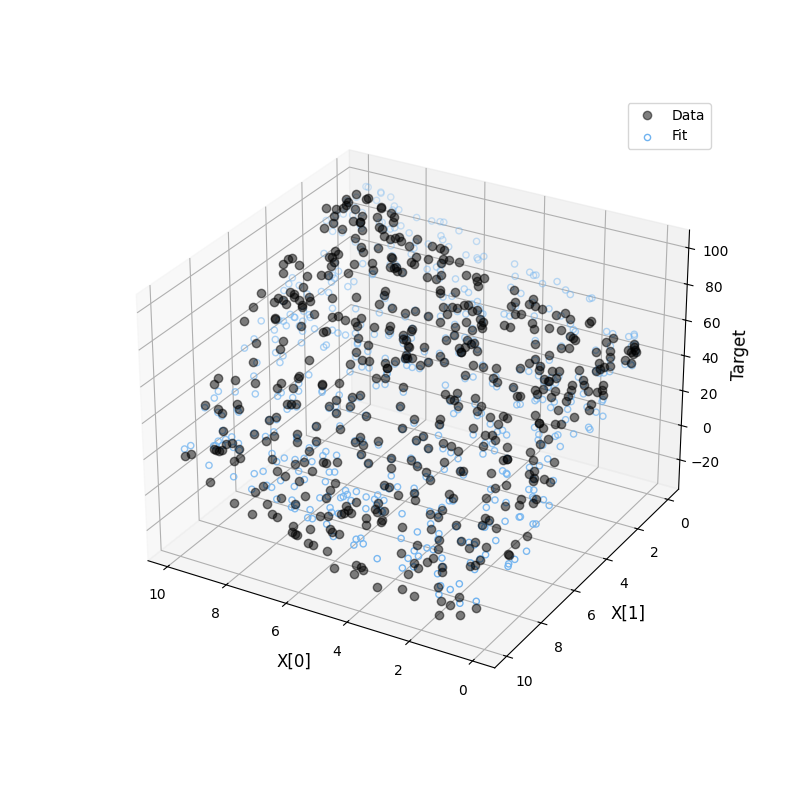

In [209]:
# Makes the plot interactive. 
# You can pan the image.
from collections.abc import Mapping
### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Feature1, Feature2, y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5, label="Data")

Prediction=model.intercept_+Feature1*model.coef_[0]+Feature2*model.coef_[1]
ax.scatter(Feature1, Feature2, Prediction, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0', label="Fit")
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)
ax.view_init(elev=28, azim=120)
ax.legend()




Ridge CV grid search cv 

In [210]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV

ridge_params = {'alphas': [0.05, 0.1, 0.2, 0.5, 1.0]}
grid = GridSearchCV(RidgeCV(), ridge_params) #grid search with ridge CV
grid.fit(np.column_stack((Feature1,Feature2)),y) 
alpha_opt = grid.best_params_['alphas'] #optimum alpha 

print("Optimum alpha: ")
print(alpha_opt)

print("Best Params: ")
print(grid.best_params_)

print("Best Score: ")
print(grid.best_score_)

Optimum alpha: 
1.0
Best Params: 
{'alphas': 1.0}
Best Score: 
0.9290800590702556


Yes, this agrees with Ridge (same alpha).

Doing ridge cv fit, printing output 

In [211]:
model = RidgeCV(alphas=alpha_opt) 
X=np.column_stack((Feature1,Feature2)) #Feature 1 in first column, Feature 2 in second column 
model.fit(X,y,yerr)
y_pred = model.predict(X)

print("y-intercept, slope for feature 1, slope for feature 2: ")
print(model.intercept_)
print(model.coef_)


y-intercept, slope for feature 1, slope for feature 2: 
56.46252180708065
[ 4.89982196 -8.14739672]


Making interactive plot for ridge cv 

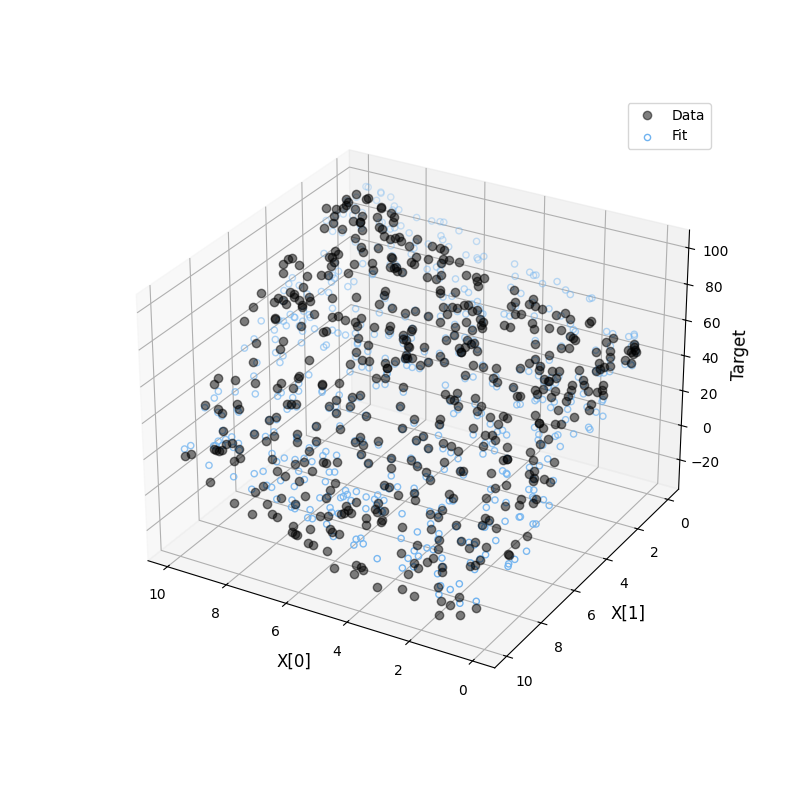

In [212]:
# Makes the plot interactive. 
# You can pan the image.
from collections.abc import Mapping
### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Feature1, Feature2, y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5, label="Data")

Prediction=model.intercept_+Feature1*model.coef_[0]+Feature2*model.coef_[1]
ax.scatter(Feature1, Feature2, Prediction, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0', label="Fit")
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)
ax.view_init(elev=28, azim=120)
ax.legend()

(500,)
(500,)


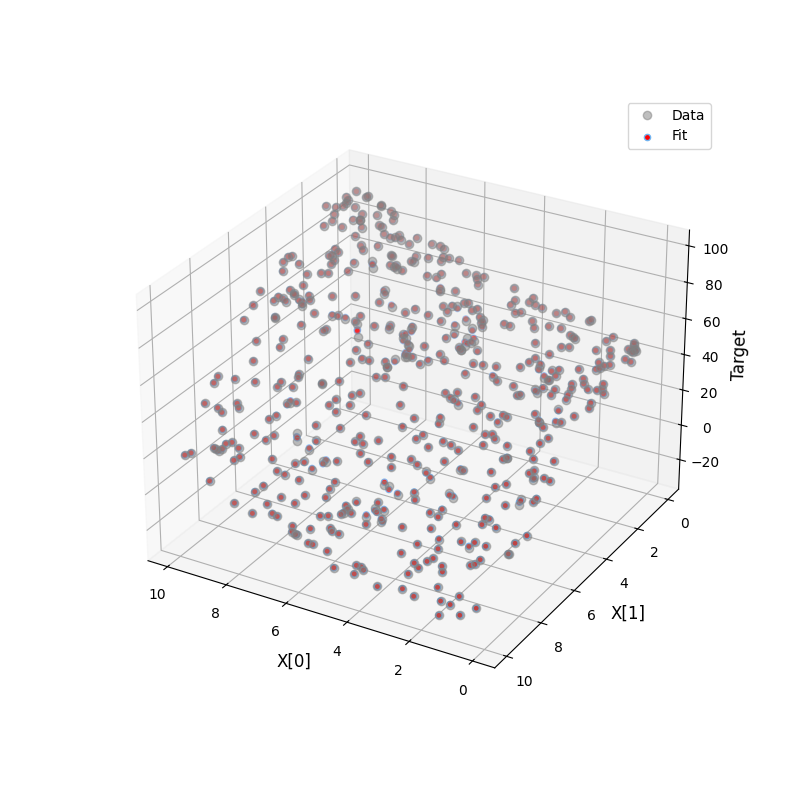

In [213]:
%matplotlib inline
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
gp1 = GaussianProcessRegressor(random_state=0, normalize_y=True)
gp1.fit(X,y)
fit = gp1.predict(X, return_std=True)

Prediction=np.transpose(fit)[:,0]

print(np.shape(Prediction))
print(np.shape(Feature1))

# Makes the plot interactive. 
# You can pan the image.
from collections.abc import Mapping
### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Feature1, Feature2, y, color='grey', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5, label="Data")

ax.scatter(Feature1, Feature2, Prediction, 
           facecolor='red', s=20, 
           edgecolor='#70b3f0', label="Fit")
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)
ax.view_init(elev=28, azim=120)
ax.legend()


This seems to be a near perfect fit! (Matches almost exactly at every point.)

Now including errors in it:

(500,)
(500,)


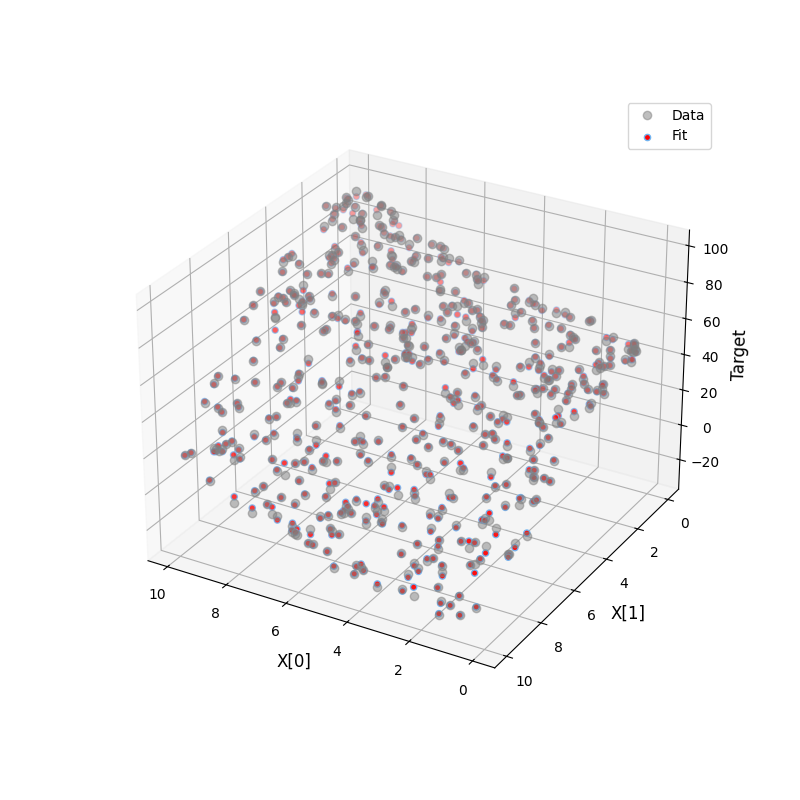

In [214]:
%matplotlib inline
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

gp2 = GaussianProcessRegressor(random_state=0, normalize_y=True, alpha=(yerr/y)**2)
gp2.fit(X,y)
fit = gp2.predict(X, return_std=True)

Prediction=np.transpose(fit)[:,0]

print(np.shape(Prediction))
print(np.shape(Feature1))

# Makes the plot interactive. 
# You can pan the image.
from collections.abc import Mapping
### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Feature1, Feature2, y, color='grey', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5, label="Data")

ax.scatter(Feature1, Feature2, Prediction, 
           facecolor='red', s=20, 
           edgecolor='#70b3f0', label="Fit")
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)
ax.view_init(elev=28, azim=120)
ax.legend()


Polynomial Regression

Fitted polynomial coefficients: 
[ 5.00363666e+01  3.26437755e-01  7.04566290e-02  3.76478281e-01
 -2.37398556e-02 -8.70986046e-01  1.19122182e-02  2.54637597e-02
 -1.32002013e-02  2.02705370e-02 -4.53796076e-04 -5.21142180e-04
 -2.06194460e-03  1.68744189e-03 -1.52054198e-03]


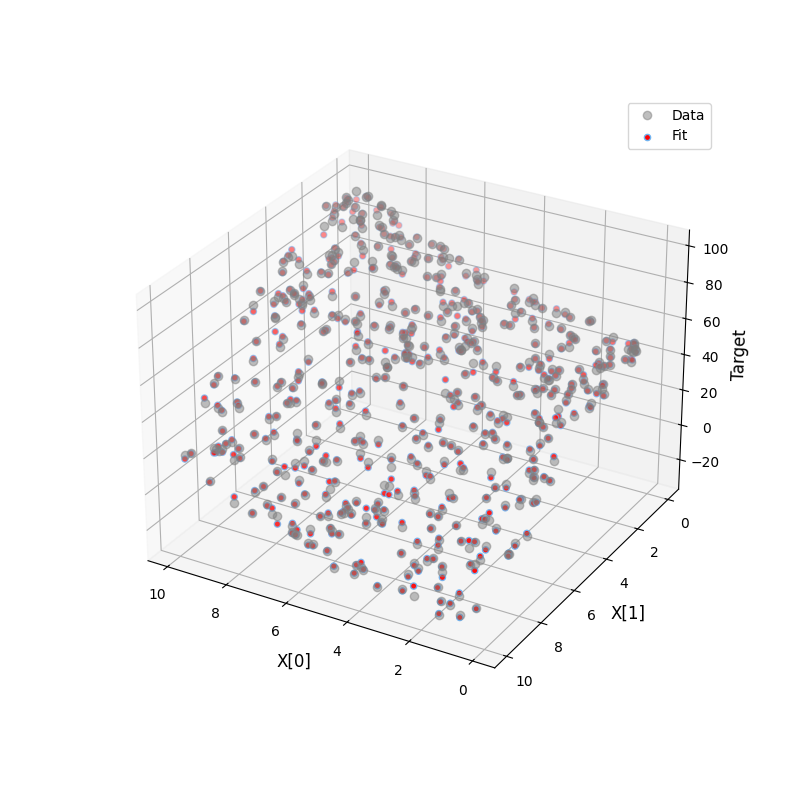

In [220]:
from astroML.linear_model import PolynomialRegression
degree=4
poly = PolynomialRegression(degree)
poly.fit(X,y)
Poly_fit_prediction_no_error = poly.predict(X)

print("Fitted polynomial coefficients: ")
print(poly.coef_)

%matplotlib inline

# Makes the plot interactive. 
# You can pan the image.
from collections.abc import Mapping
### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Feature1, Feature2, y, color='grey', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5, label="Data")

ax.scatter(Feature1, Feature2, Poly_fit_prediction_no_error, 
           facecolor='red', s=20, 
           edgecolor='#70b3f0', label="Fit")
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)
ax.view_init(elev=28, azim=120)
ax.legend()

This fit seems to be better than linear but about the same as GPR. 

Doing this again, but with errors included:

Fitted polynomial coefficients: 
[ 4.99887582e+01  5.54313398e-01 -2.07866484e-01  2.86536907e-01
  2.93842380e-03 -7.82230112e-01  2.47603263e-02  2.45748271e-02
 -2.22233559e-02  9.68417971e-03 -9.95958746e-04 -1.12284370e-03
 -1.14462222e-03  2.10142159e-03 -1.08539159e-03]
Max absolute difference between fit with error and fit without error: 
1.1137997398286217


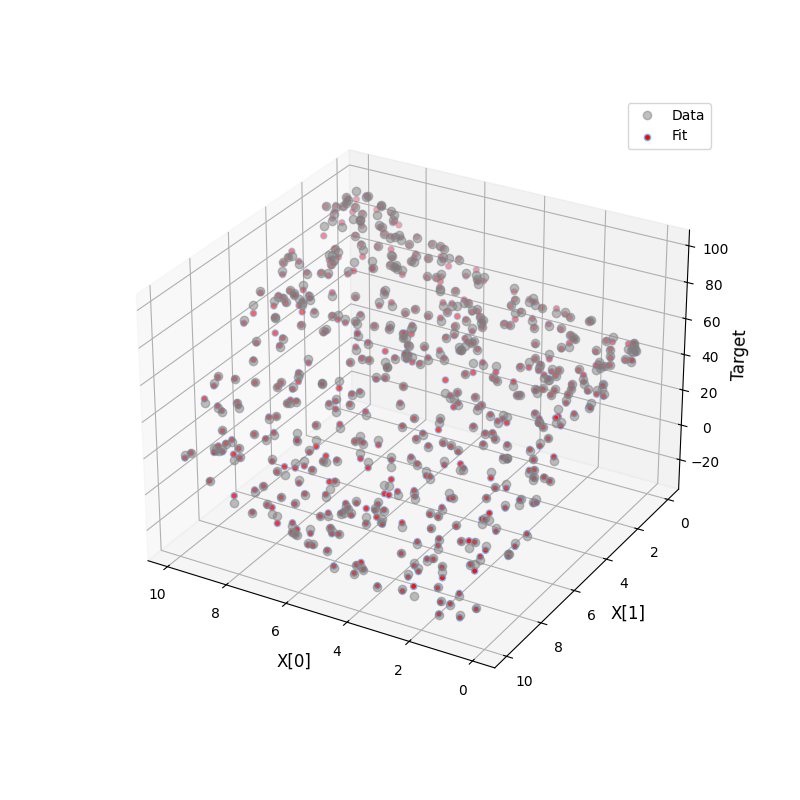

In [216]:
%matplotlib inline
from astroML.linear_model import PolynomialRegression
degree=4
poly = PolynomialRegression(degree)
poly.fit(X,y, yerr)
Poly_fit_prediction_with_error = poly.predict(X)

print("Fitted polynomial coefficients: ")
print(poly.coef_)

%matplotlib inline

# Makes the plot interactive. 
# You can pan the image.
from collections.abc import Mapping
### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Feature1, Feature2, y, color='grey', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5, label="Data")

ax.scatter(Feature1, Feature2, Poly_fit_prediction_with_error, 
           facecolor='red', s=20, 
           edgecolor='#70b3f0', label="Fit")
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)
ax.view_init(elev=28, azim=120)
ax.legend()

print("Max absolute difference between fit with error and fit without error: ")
print(np.max(np.fabs(Poly_fit_prediction_with_error-Poly_fit_prediction_no_error)))

Again, better fit than linear, about the same as GPR. 

Finding optimal hyper parameters: 

Sticking with polynomial fitting, let's find the optimal hyper-parameters through cross-validation. 
- Using `sklearn.model_selection.train_test_split`, first do a train-test split with a `test_size` of $20\%$. Then split out $20\%$ of the training set itself as a cross-validation set (leaving a somewhat smaller set to use for training). Note that you'll need to simultaneously split out `yerr` as well by just providing this as another array to `train_test_split`.
- Compute the training and cross-validation rms errors (and from those, the BIC values) as a function of polynomial degree from $1$ to $10$ inclusive. Plot the rms errors and BIC values as a function of the polynomial degree. 
- Choose the optimal polynomial degree, and train on all training data from the first `train_test_split` operation. Predict the labels of the held-out test set, and finally compute the testing rms error.

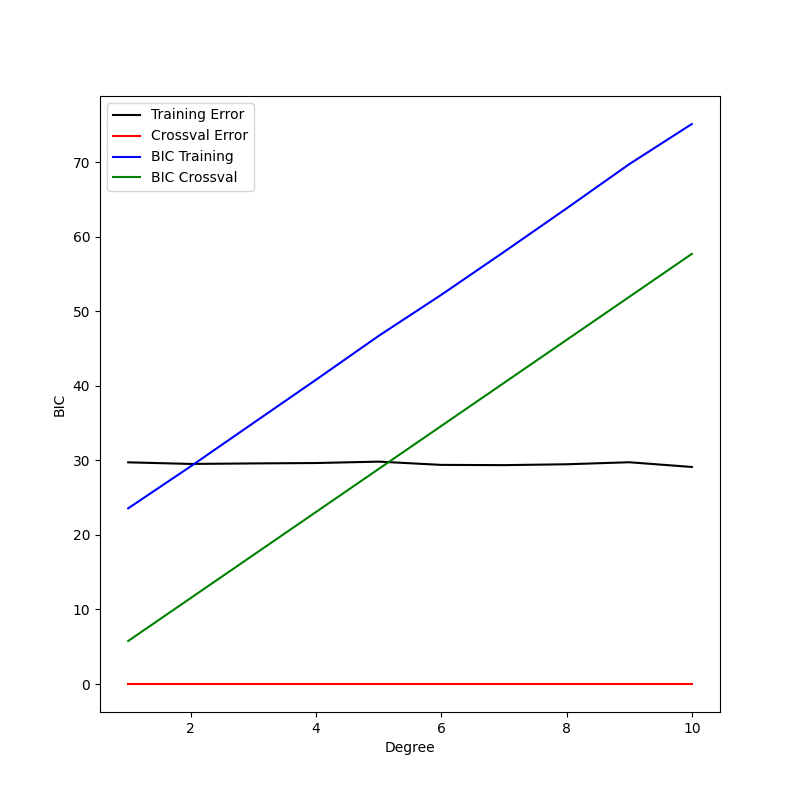

In [217]:
from astroML.linear_model import PolynomialRegression
import sklearn 

Train, Test = sklearn.model_selection.train_test_split(X, test_size=0.2)
Training_Set, Cross_Validation_Set = sklearn.model_selection.train_test_split(Train, test_size=0.2)

y_Train, y_Test = sklearn.model_selection.train_test_split(y, test_size=0.2)
y_Training_Set, y_Cross_Validation_Set = sklearn.model_selection.train_test_split(y_Train, test_size=0.2)

Train_yerr, Test_yerr = sklearn.model_selection.train_test_split(yerr, test_size=0.2)
Training_Set_yerr, Cross_Validation_Set_yerr = sklearn.model_selection.train_test_split(Train_yerr, test_size=0.2)

Degree_List=np.arange(1,11) #list from 1 to 10
Training_Err_List=[]
Crossval_Err_List=[]
BIC_Train_List=[]
BIC_CrossVal_List=[]
for degree in Degree_List:
    poly = PolynomialRegression(degree)
    poly.fit(Training_Set,y_Training_Set, Training_Set_yerr)
    Poly_fit_prediction = poly.predict(Training_Set)
    X_CV=Cross_Validation_Set
    Y_CV = poly.predict(X_CV)
    dy=np.std(y_Training_Set) #std deviation of the y values, follows example in Lecture 17 where dy is the std dev of the random data produced by a function 
    training_err_value = np.sqrt(np.sum((poly.predict(Training_Set) - y_Training_Set) ** 2) / len(y_Training_Set))
    crossval_err_value = np.sqrt(np.sum((poly.predict(X_CV) - Y_CV) ** 2) / len(Y_CV))
    BIC_train_value = np.sqrt(len(y_Training_Set)) * training_err_value / dy + degree * np.log(len(y_Training_Set))
    BIC_crossval_value = np.sqrt(len(y_Training_Set)) * crossval_err_value / dy + degree * np.log(len(y_Training_Set))
    Training_Err_List.append(training_err_value)
    Crossval_Err_List.append(crossval_err_value)
    BIC_Train_List.append(BIC_train_value)
    BIC_CrossVal_List.append(BIC_crossval_value)

plt.close()
plt.clf()

plt.plot(Degree_List, Training_Err_List, color='k', label="Training Error")
plt.plot(Degree_List, Crossval_Err_List, color='red', label="Crossval Error")
plt.xlabel("Degree")
plt.ylabel("Error")
plt.legend()

plt.plot(Degree_List, BIC_Train_List, color='blue', label="BIC Training")
plt.plot(Degree_List, BIC_CrossVal_List, color='green', label="BIC Crossval")
plt.xlabel("Degree")
plt.ylabel("BIC")
plt.legend()
plt.show()

Lowest BIC is found for the favored model. This shows the lowest BIC for a degree of one, which is a linear model, indicating that this is preferred over higher order polynomials. 
I'm unsure whether this is correct, though this is what I have found. 

Testing Error: 
35.650310054717345


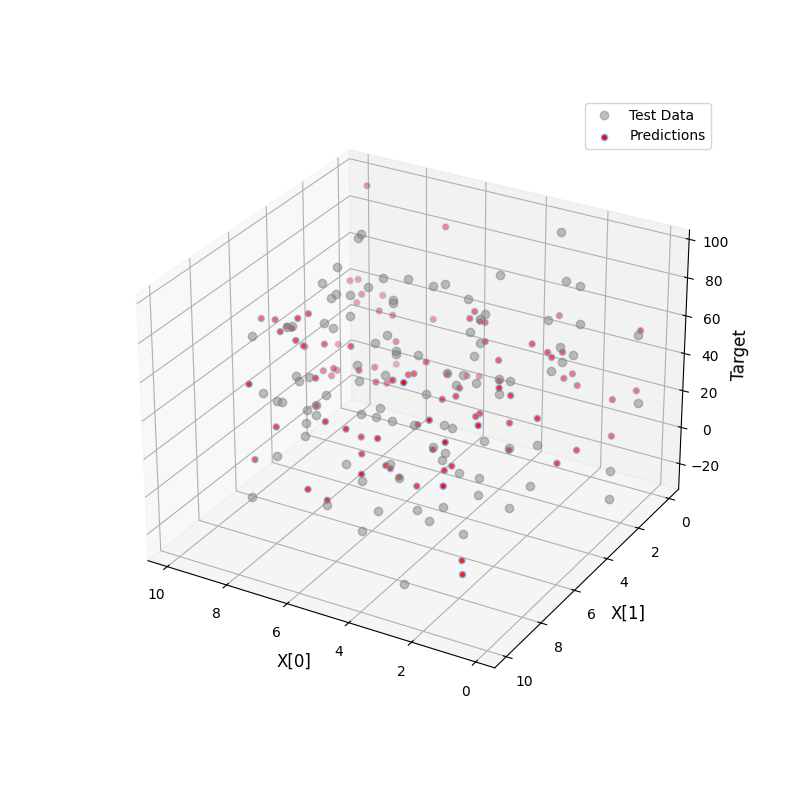

In [218]:
poly = PolynomialRegression(degree)
poly.fit(Train,y_Train, Train_yerr)
Poly_fit_prediction_final = poly.predict(Test) #Predicting labels for held out test set 
X_CV=Cross_Validation_Set
Y_CV = poly.predict(X_CV)
dy=np.std(y_Test) #std deviation of the y values, follows example in Lecture 17 where dy is the std dev of the random data produced by a function 
testing_err_value = np.sqrt(np.sum((poly.predict(Test) - y_Test) ** 2) / len(y_Test))
print("Testing Error: ")
print(testing_err_value)

%matplotlib inline

# Makes the plot interactive. 
# You can pan the image.
from collections.abc import Mapping
### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Test[:,0], Test[:,1], y_Test, color='grey', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5, label="Test Data")

ax.scatter(Test[:,0], Test[:,1], Poly_fit_prediction_final, 
           facecolor='red', s=20, 
           edgecolor='#70b3f0', label="Predictions")
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)
ax.view_init(elev=28, azim=120)
ax.legend()

This doesn't look great. Mistake somewhere? 